Single spillover (non-recurrent) branching process (infinite population), plots probabilities of outbreak.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###################################################
# simulates infection WITHOUT recurrent spillover 
# allows both gamma and beta to mutate            
#
# note: this implementation branches people in "generation order" instead of in "time order"
# (faster to run, and still gives the same result in the limit as outbreak_thresh -> infinity)
# for an implementation done in time order, see the function sim_class
#
# also note that if the infection goes extinct the time of extinction is well-defined, and either implementation computes it correctly.
###################################################
#
# input beta_0 is transmission rate of the initial case.
# input gamma_0 is recovery rate of the initial case. 
#
# optional input mu_1 represents mutation rate for beta. If unspecified, defaults to 0.
# optional input mu_2 represents mutation rate for gamma. If unspecified, defaults to 0.
#
###################################################
#
# returns 0, t_ext if extinction, where t_ext is time of extinction. 
# returns 1 if outbreak
#
###################################################

def sim(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t = 0
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=[[beta_0, gamma_0, t]]
    
    N_infected = len(infecteds) #keep track of number of infected people
    
    t_ext = None #time of extinction, will fill this value and return it if the infection goes extinct
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        #keeps track of indices of recovered people
        #will delete them from array of infecteds at the end of each while loop iteration
        recovereds = []
        
        for i, person in enumerate(infecteds): #go through and branch each person in array of infecteds

            #print("\n", "branching person", i)
            
            [beta, gamma, t] = person
            
            while True:
                                
                #interevent time
                #note this is interevent time for ONE person, NOT for entire population
                dt = np.random.exponential(scale = 1/(beta + gamma))
                new_t = t + dt #time of new event
                
                #pick which new event happens, transmission or recovery         
                ev = np.random.rand() #draw number from uniform distribution over [0, 1)
                prob_trans = beta / (beta+gamma)

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    #pick beta and gamma for new case
                    #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
                    #don't allow negative beta.
                    #don't allow gamma to be less than a small value, the natural death rate.
                    mut1 = np.random.normal(loc=0.0, scale=mu_1)
                    new_beta = max(0, beta + mut1)
                    mut2 = np.random.normal(loc=0.0, scale=mu_2)              
                    nat_death = 0.00002366575 #taken from CDC: https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
                    new_gamma = max(nat_death, gamma + mut2)
                    
                    #append new person to array of infecteds
                    infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                    N_infected += 1
                    
                    if N_infected >= outbreak_thresh:
                        #print("\n", "outbreak!")
                        return 1

                    #print("new infection: ", [new_beta, new_gamma, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
 
                    if N_infected == 0:
                        #print("\n", "extinction")
                        return 0, new_t
                    
                    #mark index of this recovered person, in order to delete them later
                    #(we don't delete yet, because that will mess up the indexing of the for loop)
                    recovereds.append(i)
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #update the array of infecteds by deleting recoveries
        infecteds = np.delete(infecteds, recovereds, axis=0)

In [3]:
#####################################################
# runs many simulations WITHOUT recurrent spillover #
#####################################################
#
# optional input N_sims is number of simulations to run.
#
# returns the percentage of those simulations that outbreak
#
#########################

def sim_percentage(beta_0, gamma_0, mu_1=0, mu_2=0, N_sims=1000):   
    N_outbreaks = 0  
    for i in range(N_sims):
        if sim(beta_0, gamma_0, mu_1, mu_2) == 1: N_outbreaks += 1
    return N_outbreaks/N_sims

In [4]:
# run a single simulation

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.01
mu_2 = 0.01

sim(beta_0, gamma_0, mu_1, mu_2)

(0, 9.554513192775026)

In [5]:
# run a bulk simulation

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1=0.0001
mu_2=0.0001

sim_percentage(beta_0, gamma_0, mu_1, mu_2, N_sims=10000)

0.0

In [6]:
#################################################################
# for a fixed mu, plots the probability of outbreak against R_0 #
#################################################################
#
# input mu = mu_1 = mu_2
#
# optional inputs R0_min, R0_max give range of R_0 to plot over.
# optional input N_points gives number of points to plot.
# optional inputs N_sims gives number of simulations to run per point.
#
################################################################

def prob_plot(mu, R0_min=0.001, R0_max=2.5, N_points = 75, N_sims=750):
    
    # Take some evenly spaced R_0 values
    # Note that it does matter what beta and gamma are, even if they give the same R_0. 
    # But here we're just fixing gamma to be 0.1
    # TO DO later: explore other choices.
    beta_range = np.linspace(R0_min/10, R0_max/10, N_points); gamma = 0.1
    
    # initialize arrays to be plotted
    R0 = []; percent = []

    #simulate percentages of outbreak
    for beta in beta_range:
        R0 = np.append(R0, beta/gamma)
        percent = np.append(percent, sim_percentage(beta, gamma, mu, mu, N_sims))
        
    #make the plot
    plt.plot(R0, percent, "ob")
    #graph the actual probability of outbreak with no mutation
    #################################################################
    # From Linda's talk: the actual probability of outbreak with no mutation is:
    #                            0 if R_0 < 1
    #                            1-1/R_0 = 1-gamma/beta if R_0 > 1
    #################################################################
    plt.plot(R0, np.piecewise(R0, [R0<1, R0>=1], [0, lambda R0: 1-1/R0]), "r", label='probability without mutation')
    plt.title('mu1 = mu2 = {}'.format(mu))
    plt.xlabel("R_0"); plt.ylabel("p")
    plt.xlim(R0_min, R0_max)
    plt.legend()
    plt.show()

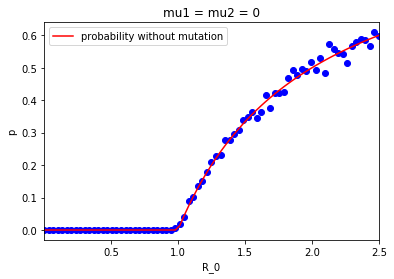

CPU times: user 1min 34s, sys: 833 ms, total: 1min 34s
Wall time: 1min 41s


In [7]:
%%time

# SANITY CHECK
# When there is no mutation, check that our simulation agrees with the correct probability

prob_plot(mu=0)

Simulate some other values of mu. Note the scale changes on the axes

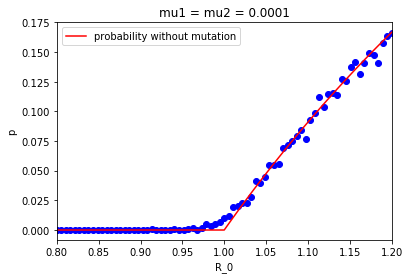

CPU times: user 4min 22s, sys: 2.62 s, total: 4min 24s
Wall time: 4min 42s


In [12]:
%%time

#zoom in
prob_plot(mu=0.0001, R0_min=0.8, R0_max=1.2, N_points = 75, N_sims=2000)

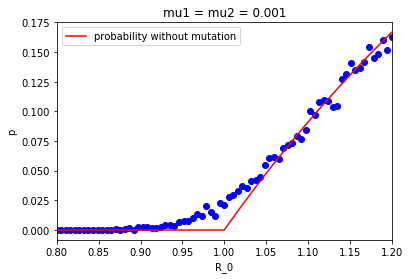

CPU times: user 3min 55s, sys: 2.19 s, total: 3min 57s
Wall time: 4min 11s


In [13]:
%%time

prob_plot(mu=0.001, R0_min=0.8, R0_max=1.2, N_points = 75, N_sims=2000)

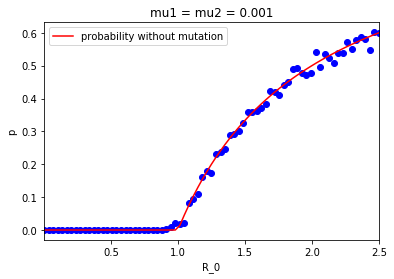

CPU times: user 1min 28s, sys: 639 ms, total: 1min 28s
Wall time: 1min 30s


In [14]:
%%time

#zoom back out
prob_plot(mu=0.001)

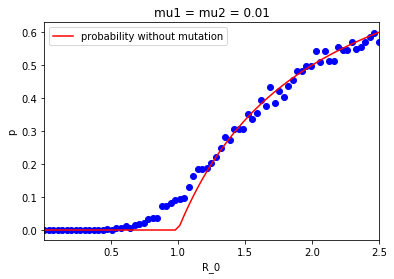

CPU times: user 1min 17s, sys: 628 ms, total: 1min 18s
Wall time: 1min 22s


In [15]:
%%time

prob_plot(mu=0.01)

In [ ]:
%%time

prob_plot(mu=0.1)

In [ ]:
%%time

#zoom out more
prob_plot(mu=0.1, R0_max=10)

In [ ]:
%%time

prob_plot(mu=0.5, R0_max=10)

In [ ]:
%%time

prob_plot(mu=1, R0_max=30)

The next part generates some more graphs and visualizations.